In [1]:
# import dependencies
import json
import math
import os
from collections import Counter
import itertools
from PIL import Image
from tqdm import tqdm
import gc
from functools import partial

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import tensorflow as tf
from keras import layers
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

%matplotlib inline

In [2]:
# Self-defined functions
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    #IMG = []
    BIMG = []
    MIMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        
        name, ftype = os.path.splitext(PATH)
#         print(name)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            if name[11:16] == 'train':
                if name[26] =='B':
                    BIMG.append(np.array(img))
                elif name[26]== 'M':
                    MIMG.append(np.array(img))
            #IMG.append(np.array(img))
            else:
                if name[25] == 'B':
                    BIMG.append(np.array(img))
                elif name[25] == 'M':
                    MIMG.append(np.array(img))
    return BIMG, MIMG

In [20]:
BATCH_SIZE = 16
EPOCH = 20

### Load dataset

In [3]:
f1_b_train, f1_m_train = Dataset_loader('data/fold1/train/200X', 224)
f1_b_train = np.array(f1_b_train)
f1_m_train = np.array(f1_m_train)

f2_b_train, f2_m_train = Dataset_loader('data/fold2/train/200X', 224)
f2_b_train = np.array(f2_b_train)
f2_m_train = np.array(f2_m_train)

f3_b_train, f3_m_train = Dataset_loader('data/fold3/train/200X', 224)
f3_b_train = np.array(f3_b_train)
f3_m_train = np.array(f3_m_train)

f4_b_train, f4_m_train = Dataset_loader('data/fold4/train/200X', 224)
f4_b_train = np.array(f4_b_train)
f4_m_train = np.array(f4_m_train)

f5_b_train, f5_m_train = Dataset_loader('data/fold5/train/200X', 224)
f5_b_train = np.array(f5_b_train)
f5_m_train = np.array(f5_m_train)

100%|██████████| 1243/1243 [00:18<00:00, 67.08it/s]


In [4]:
f1_b_test, f1_m_test = Dataset_loader('data/fold1/test/200X', 224)
f1_b_test = np.array(f1_b_test)
f1_m_test = np.array(f1_m_test)

f2_b_test, f2_m_test = Dataset_loader('data/fold2/test/200X', 224)
f2_b_test = np.array(f2_b_test)
f2_m_test = np.array(f2_m_test)

f3_b_test, f3_m_test = Dataset_loader('data/fold3/test/200X', 224)
f3_b_test = np.array(f3_b_test)
f3_m_test = np.array(f3_m_test)

f4_b_test, f4_m_test = Dataset_loader('data/fold4/test/200X', 224)
f4_b_test = np.array(f4_b_test)
f4_m_test = np.array(f4_m_test)

f5_b_test, f5_m_test = Dataset_loader('data/fold5/test/200X', 224)
f5_b_test = np.array(f5_b_test)
f5_m_test = np.array(f5_m_test)

100%|██████████| 770/770 [00:10<00:00, 70.12it/s]


In [5]:
b_train = np.concatenate((f1_b_train, f2_b_train, f3_b_train, f4_b_train, f5_b_train), axis=0)
m_train = np.concatenate((f1_m_train, f2_m_train, f3_m_train, f4_m_train, f5_m_train), axis=0)
b_test = np.concatenate((f1_b_test, f2_b_test, f3_b_test, f4_b_test, f5_b_test), axis = 0)
m_test = np.concatenate((f1_m_test, f2_m_test, f3_m_test, f4_m_test, f5_m_test), axis = 0)

In [7]:
print('benign traning size:', b_train.shape)
print('malian traning size:', m_train.shape)
print('benign testing size:', b_test.shape)
print('malian testing size:', m_test.shape)

benign traning size: (2001, 224, 224, 3)
malian traning size: (4615, 224, 224, 3)
benign testing size: (1114, 224, 224, 3)
malian testing size: (2335, 224, 224, 3)


### Create Label

In [8]:
b_train_label = np.zeros(len(b_train))
m_train_label = np.ones(len(m_train))
b_test_label = np.zeros(len(b_test))
m_test_label = np.ones(len(m_test))

In [9]:
# Merge data 
X_train = np.concatenate((b_train, m_train), axis = 0)
Y_train = np.concatenate((b_train_label, m_train_label), axis = 0)
X_test = np.concatenate((b_test, m_test), axis = 0)
Y_test = np.concatenate((b_test_label, m_test_label), axis = 0)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6616, 224, 224, 3)
(6616,)
(3449, 224, 224, 3)
(3449,)


In [11]:
# radomly shuffle the data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

### Train and validation split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

### Data Generator

In [13]:
# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

### Model: ResNet50

In [17]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    return model

In [15]:
K.clear_session()
gc.collect()

58

In [16]:
# create ResNet model
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [18]:
model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 2)                 3842      
Total params: 18,333,506
Trainable params: 18,100,610
Non-trainable params: 232,896
_________________________________________________________________


In [23]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### Start training and store result into history

In [24]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=EPOCH,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
330/330 [==============================] - 2304s 7s/step - loss: 0.2551 - accuracy: 0.9000 - val_loss: 0.2767 - val_accuracy: 0.8739

Epoch 00001: val_accuracy improved from -inf to 0.87387, saving model to weights.best.hdf5
Epoch 2/20
330/330 [==============================] - 2405s 7s/step - loss: 0.1943 - accuracy: 0.9295 - val_loss: 0.1218 - val_accuracy: 0.9615

Epoch 00002: val_accuracy improved from 0.87387 to 0.96148, saving model to weights.best.hdf5
Epoch 3/20
330/330 [==============================] - 2510s 8s/step - loss: 0.1741 - accuracy: 0.9320 - val_loss: 0.1469 - val_accuracy: 0.9403

Epoch 00003: val_accuracy did not improve from 0.96148
Epoch 4/20
330/330 [==============================] - 2260s 7s/step - loss: 0.1595 - accuracy: 0.9405 - val_loss: 0.0617 - val_accuracy: 0.9751

Epoch 00004: val_accuracy improved from 0.96148 to 0.97508, saving model to weights.best.hdf5
Epoch 5/20
330/330 [==============================] - 2196s 7s/step - loss: 0.1426 - a

### Data Analysis

In [25]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

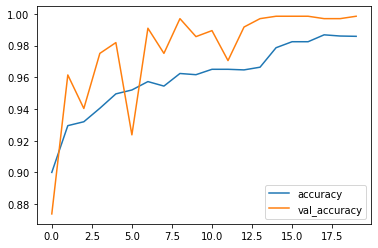

In [30]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

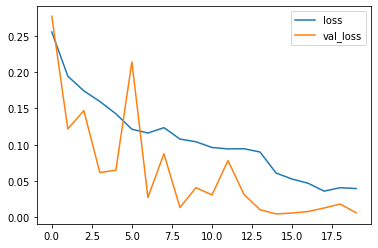

In [31]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

#### Load weights and print validation result

In [32]:
model.load_weights("weights.best.hdf5")

In [33]:
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9984894259818731

In [ ]:
Y_pred = model.predict(X_test)
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

### More Complicated version

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

num_classes = 2
def cnn(train_X, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (5, 5), strides = (1,1), padding='same', 
                 input_shape=train_X.shape[1:]))  # 第一层需要指出图像的大小
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Conv2D(64, (5, 5), strides = (1,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Conv2D(128, (5, 5), strides = (1,1)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(1,1)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    print(model.summary())

In [ ]:
import keras
model = cnn(x_train,num_classes)

    
lr=0.01
epoch = 5
opt = keras.optimizers.rmsprop(lr, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy'])

# here we use the test_set as the validation_set    
model.fit(x_train,y_train,
          batch_size=32,
          epochs=epoch,
          verbose=1,
          validation_data=(x_val,y_val), 
          callbacks=[learn_control, checkpoint]
         )
score = model.evaluate(x_val,y_val,verbose=0)
print(score)

In [ ]:
import keras
model = cnn(x_train,num_classes)